<h3>Imports</h3>

In [24]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'pandas_profiling'

<h3>Conjunto de dados</h3>

In [20]:
car_evaluation = fetch_openml(name="car", version=3, parser='auto')
df = pd.DataFrame(data=car_evaluation.data, columns=car_evaluation.feature_names)
df['target'] = car_evaluation.target

<h3>Verifica se há valores ausentes</h3>

In [21]:
print("Valores Ausentes: ")
print(df.isnull().sum())

Valores Ausentes: 
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
target      0
dtype: int64


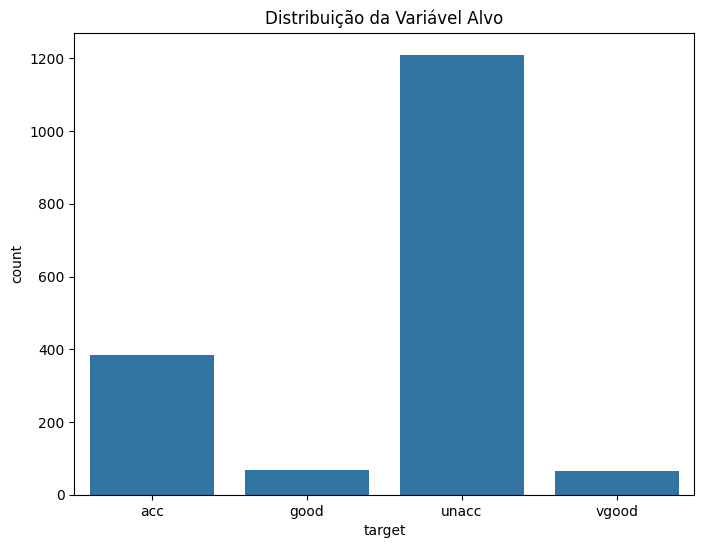

<Figure size 1500x1000 with 0 Axes>

Não há variáveis numéricas para calcular a matriz de correlação.


In [23]:
# Visualizações para Análise Exploratória de Dados (EDA)
# Distribuição da Variável Alvo
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Distribuição da Variável Alvo')
plt.show()

# Distribuição de Variáveis Numéricas
numeric_columns = df.select_dtypes(include=['float64']).columns
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f'Distribuição de {column}')
    plt.show()

# Relação entre Variáveis Categóricas e a Variável Alvo
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.select_dtypes(include=['object']).columns):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=column, hue='target', data=df)
    plt.title(f'Relação entre {column} e a Variável Alvo')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Matriz de Correlação para Variáveis Numéricas
if not df[numeric_columns].empty:
    correlation_matrix = df[numeric_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Matriz de Correlação')
    plt.show()
else:
    print("Não há variáveis numéricas para calcular a matriz de correlação.")

In [ ]:
# Caracterização da base de dados
num_attributes = len(df.columns) - 1  # Excluindo a coluna alvo 'target'
num_instances = len(df)
num_classes = len(df['target'].unique())

print("\nCaracterização da Base de Dados:")
print(f"Número de Atributos: {num_attributes}")
print(f"Número de Instâncias: {num_instances}")
print(f"Número de Classes: {num_classes}")

# Divisão do conjunto de dados em treinamento e teste
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("\nDimensões dos Conjuntos de Treinamento e Teste:")
print(f"Treinamento - X: {X_train.shape}, y: {y_train.shape}")
print(f'Teste - X: {X_test.shape}, y: {y_test.shape}')



Caracterização da Base de Dados:
Número de Atributos: 6
Número de Instâncias: 1728
Número de Classes: 4

Dimensões dos Conjuntos de Treinamento e Teste:
Treinamento - X: (1209, 6), y: (1209,)
Teste - X: (519, 6), y: (519,)
